In [36]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

## read into data，re-format timestamp for future use 

In [37]:
dataset  = pd.read_csv("dataset_test_BHVR.csv",sep = ";")
dataset["new_Timestamp"] = [i.split('T')[0] for i in list(dataset['Timestamp'] )]
labels, levels = pd.factorize(dataset['new_Timestamp'])
dataset["days_Timestamp"] = labels+1

## count new users / remaining users for each day, make the area plot

In [38]:
remaining=[]
new=[]
def cal_remaining_new(dataset,days):
    for day in days:
        dataset1  = dataset.loc[dataset['days_Timestamp']==day]
        remaining.append(dataset1.loc[dataset1['new']==False].shape[0])
        new.append(dataset1.loc[dataset1['new']==True].shape[0])
    return remaining, new
remaining_list,new_list= cal_remaining_new(dataset=dataset,days= np.unique(dataset['days_Timestamp']).tolist())

## count new users who win the game and new users who lose the game for each day, for line plot

In [39]:
new_win = []
new_lose = []
new_num = []
def cal_new_win_lose(dataset,days):
    for day in days:
        dataset1  = dataset.loc[(dataset['days_Timestamp']==day) & (dataset['new']==True)]
        new_num.append(dataset1.shape[0])
        new_win.append(dataset1.loc[dataset1['win']==True].shape[0])
        new_lose.append(dataset1.loc[dataset1['win']==False].shape[0])
    return new_num ,new_win, new_lose
new_num_list,new_win_list,new_lose_list = cal_new_win_lose(dataset=dataset,days =  np.unique(dataset['days_Timestamp']).tolist())

## show area plot(green area as remaining users, grey region as new users) with line plot(red,which indicates win propotion in new users for each day) 
### as we expect the high win propotion in new users will affect the remaining users in a delayed manner, we postponed 7 days by shifting the line horizontally by 7 units(red dash line)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


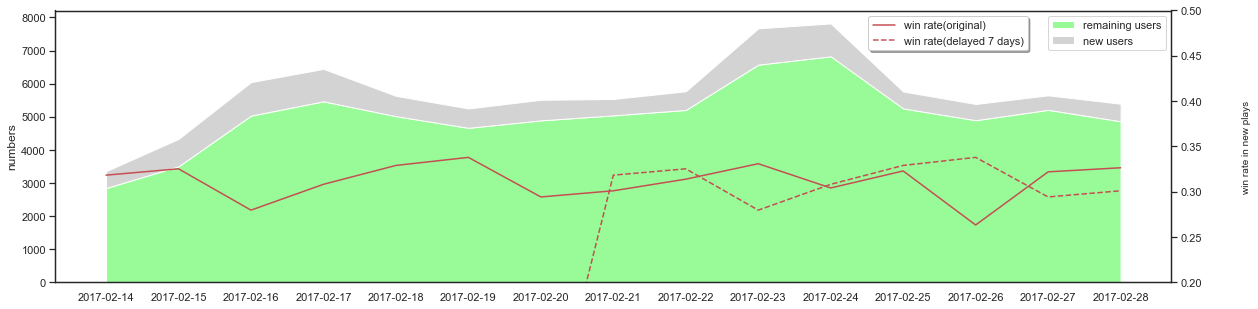

In [40]:
ori_win_rate_in_new = [x/y for x, y in zip(new_win_list, new_num_list)]
delayed_win_rate_in_new = ([0,0,0,0,0,0,0] + [x/y for x, y in zip(new_win_list, new_num_list)])[:15]
line_rates = [  ori_win_rate_in_new,delayed_win_rate_in_new]
color_line_rates = ['r','r--']
plt.figure(figsize=(20,5))
plt.stackplot( np.unique(dataset['new_Timestamp']).tolist(),remaining_list, new_list,colors=['palegreen','lightgrey'])
plt.gca().legend(('remaining users','new users'))
plt.ylabel("numbers")
ax1 = plt.axes()
axes2 = ax1.twinx()
for line_rate,col in zip(line_rates,color_line_rates):
    a,b = 0.2,0.5
    axes2.set_ylim(a,b)
    axes2.set_ylabel('win rate in new plays',rotation="vertical", fontsize=10, labelpad=40)
    axes2.plot(line_rate,col)
axes2.legend( ["win rate(original)","win rate(delayed 7 days)"], loc='upper center',bbox_to_anchor=(0.8, 1.0),shadow=True, ncol=1)


## calculate retention after "gap" day since "start" day

In [41]:
def cal_rates(dataset,start,gap= 6):
    end = start+gap
    df_start = dataset.loc[dataset['days_Timestamp'] == start]
    df_end = dataset.loc[dataset['days_Timestamp'] == end]
    start_id_win_new = df_start.loc[(df_start['win']==True) & (df_start['new']==True)]['player_id']
    start_id_lose_new = df_start.loc[(df_start['win']==False) & (df_start['new']==True)]['player_id']
    a=  list(set(df_end['player_id']).intersection(set(start_id_win_new)))
    c=  list(set(df_end['player_id']).intersection(set(start_id_lose_new)))
    win_new_rate =  len(a) / len(start_id_win_new)
    lose_new_rate = len(c) / len(start_id_lose_new)
    return win_new_rate,lose_new_rate

In [42]:
start_day = list(range(1, 16))
win_new_rate_cohert2,lose_new_rate_cohert2 = [],[]
for ii in start_day:
    win_new_rate_cohert,lose_new_rate_cohert=[],[]
    for jj in list(range(1,(16-ii))):
        win_new_rate_cohert1,lose_new_rate_cohert1 =  cal_rates(dataset,start = ii,gap=jj)
        win_new_rate_cohert.append(win_new_rate_cohert1)
        lose_new_rate_cohert.append(lose_new_rate_cohert1)
    win_new_rate_cohert2.append(win_new_rate_cohert)
    lose_new_rate_cohert2.append(lose_new_rate_cohert)


In [43]:
new_cohorts = pd.DataFrame(lose_new_rate_cohert2) + pd.DataFrame(win_new_rate_cohert2).values
new_cohorts.insert(0, '0.0', '1')
new_cohorts.columns =list(range(0,15))
new_cohorts.index = list(np.unique(dataset['new_Timestamp'].values))
new_cohorts = new_cohorts[new_cohorts.columns].astype(float)  

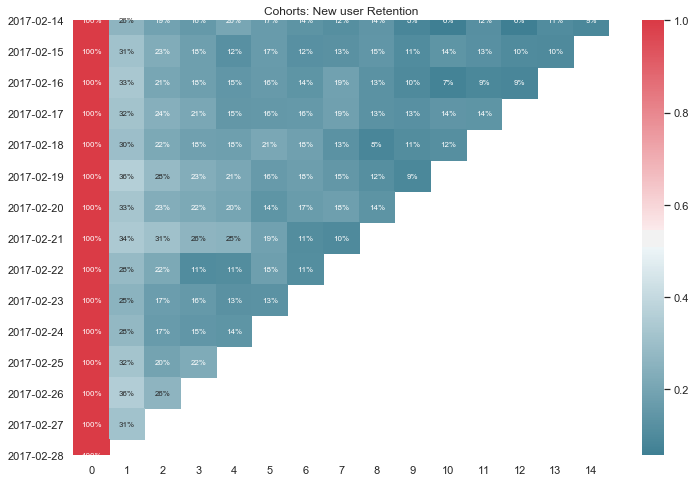

In [44]:
sns.set(style="white")
plt.figure(figsize=(12, 8))
plt.title('Cohorts: New user Retention')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns_plot = sns.heatmap(new_cohorts, mask=new_cohorts.isnull(),cmap=cmap,annot = True,annot_kws={"size": 8},fmt='.0%')
sns_plot.figure.savefig("new_cohorts.png",bbox_inches='tight')

In [45]:
new_win_cohorts = pd.DataFrame(win_new_rate_cohert2)
new_win_cohorts.insert(0, '0.0', '1')
new_win_cohorts.columns =list(range(0,15))
new_win_cohorts.index = list(np.unique(dataset['new_Timestamp'].values))
new_win_cohorts = new_win_cohorts[new_win_cohorts.columns].astype(float)  

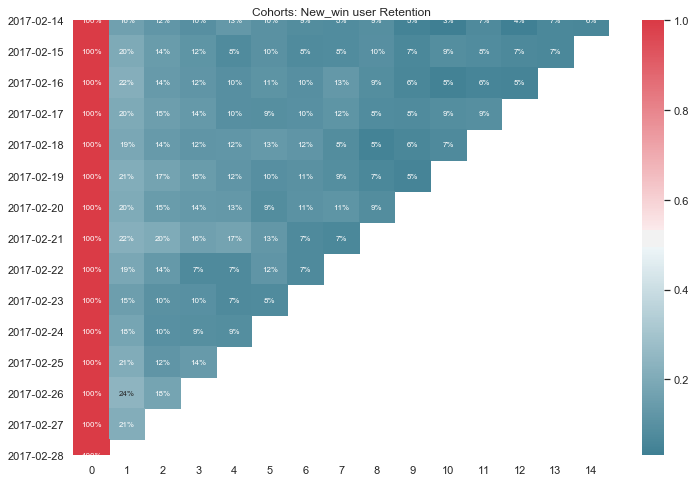

In [46]:
plt.figure(figsize=(12, 8))
plt.title('Cohorts: New_win user Retention')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns_plot1 = sns.heatmap(new_win_cohorts, mask=new_win_cohorts.isnull(),cmap=cmap,annot = True,annot_kws={"size": 8},fmt='.0%')
sns_plot1.figure.savefig("new_win_cohorts.png",bbox_inches='tight')


In [47]:
new_lose_cohorts = pd.DataFrame(lose_new_rate_cohert2)
new_lose_cohorts.insert(0, '0.0', '1')
new_lose_cohorts.columns =list(range(0,15))
new_lose_cohorts.index = list(np.unique(dataset['new_Timestamp'].values))
new_lose_cohorts = new_lose_cohorts[new_lose_cohorts.columns].astype(float)  

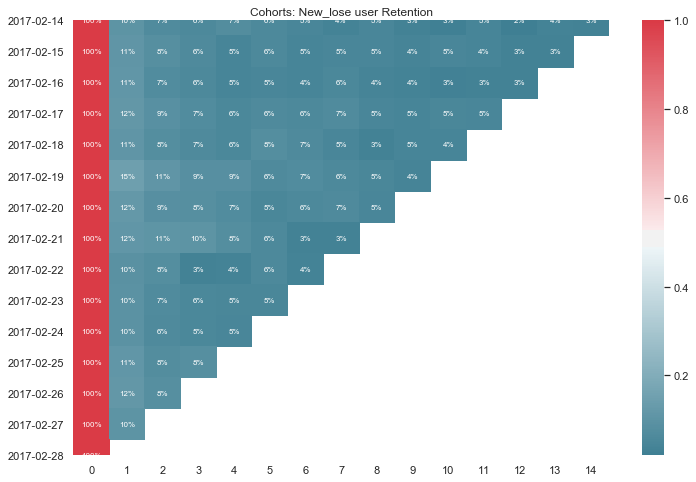

In [48]:
plt.figure(figsize=(12, 8))
plt.title('Cohorts: New_lose user Retention')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns_plot2 = sns.heatmap(new_lose_cohorts, mask=new_lose_cohorts.isnull(),cmap=cmap,annot = True,annot_kws={"size": 8},fmt='.0%')
sns_plot2.figure.savefig("new_lose_cohorts.png",bbox_inches='tight')


## D7 retention caculated by (Day1,Day7),(Day2,Day8),...,(Day9,Day15) for 2 new user groups(win_new,lose_new )

In [49]:
start = [1,2,3,4,5,6,7,8,9]
rates = []
for i in start:
    rate = cal_rates(dataset,i)
    rates.append(rate)
rate_metric = pd.DataFrame(rates)
rate_metric.columns = ['win_new_D7','lose_new_D7',]
rate_metric['start_day'] = list(np.unique(dataset['new_Timestamp']))[0:9]
rate_metric['end_day'] = list(np.unique(dataset['new_Timestamp']))[6:15]

In [50]:
rate_metric

,win_new_D7,lose_new_D7,start_day,end_day
0,0.086420,0.048991,2017-02-14,2017-02-20
1,0.078067,0.046595,2017-02-15,2017-02-21
2,0.095406,0.043896,2017-02-16,2017-02-22
3,0.099338,0.058997,2017-02-17,2017-02-23
4,0.118812,0.065534,2017-02-18,2017-02-24
5,0.106061,0.072165,2017-02-19,2017-02-25
6,0.109290,0.059226,2017-02-20,2017-02-26
7,0.073826,0.034682,2017-02-21,2017-02-27
8,0.073446,0.038760,2017-02-22,2017-02-28


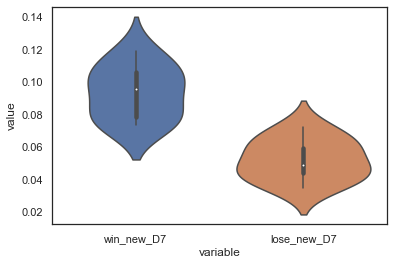

In [51]:
sns.violinplot(x="variable", y="value", data=pd.melt(rate_metric[['win_new_D7','lose_new_D7']]))

## Three T tests between win_new and lose_new group:
## H0: D7 retention in win_new group have identical average values with D7 retention in lose_new group. (reject when p<0.05)

In [52]:
a = stats.ttest_ind(rate_metric['win_new_D7'],rate_metric["lose_new_D7"])
t_stats = a.statistic
p_value = a.pvalue
print("we reject H0 with p value {} <0.05.Saying win_new group does have a larger average retention value than that of lose_new group with statistics {} >0".format(p_value,t_stats))

we reject H0 with p value 1.9127239678941084e-05 <0.05.Saying win_new group does have a larger average retention value than that of lose_new group with statistics 5.983001182578937 >0
